# To-do list

## Metalicty

# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>
Posterior predictive checks 
Use Gyrs 



# rotaation bv and age observers GC
# period age mass and metalictty fundemental GC


In [ ]:
!pip install arviz==0.11.0
!pip install pymc3==3.11.1
!pip install PyAstronomy


     |████████████████████████████████| 1.6MB 8.8MB/s 
     |████████████████████████████████| 768kB 42.0MB/s 
     |████████████████████████████████| 4.7MB 40.5MB/s 
     |████████████████████████████████| 317kB 44.0MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 870kB 8.2MB/s 
     |████████████████████████████████| 1.8MB 45.6MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-cp37-none-any.whl size=1529948 sha256=84a40ef03eb92dc89a1b344122d85ba774bbc9b31be18c91bb9ac2bc0dc71105
  Stored in directory: /root/.cache/pip/wheels/bd/5a/32/a5690ce4309abc60e1776ad3d3b408ead6da77ccced26ee723
Successfully built theano-pymc


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import pandas as pd

import pymc3 as pm
import theano as tt
import arviz 
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

In [3]:
def mean_fn(t, B, A, c, h, f, m, k):
  return A * (t)**c  * (B-h)**f * (m+1)**k





# (1+ metalicity)^( positive small power much less than 1 hundreth)
# upper bound 1/10
# higher metalicty higher period

# for latent parameters
# when we do gp.predict and pass trace


def log_err(vals, val, err_lo):
  return np.mean(np.log(vals)) - np.log(np.mean(vals)- err_lo) ## this works 



def lin_err(val, sig_hi, sig_lo):
  return (sig_hi +sig_lo)/2
  

In [4]:
##### OPTIONS #####
#data1 16th points = 91 total






data = pd.read_csv('/content/drive/My Drive/data/real_data.csv', header=0)
flag = np.array(data['flag'])

Teff = np.array(data['Teff'])

Teff_err = np.array(data['eTeff'])

Age = np.array(data['age']) # convert to Megayrs
Age_err_lo = np.array(data['loage'])
Age_err_hi = np.array(data['upage'])

Prot = np.array(data['P'])
Prot_err_lo = np.array(data['l_P'])
Prot_err_hi = np.array(data['u_P'])

Mass  = np.array(data['modmass'])
Mass_err_lo = np.array(data['lomodmass'])
Mass_err_hi = np.array(data['upmodmass'])

metal = np.array(data['feh'])

b = pyasl.BallesterosBV_T()
data_points = Prot.shape[0]


#Prot_err = np.array([lin_err(Prot, Prot[i], Prot_err_lo[i]) for i in range(data_points)])
#Age_err = np.array([lin_err(Age, Age[i], Age_err_lo[i]) for i in range(data_points)])

Age_err = np.array([lin_err(Age[i], Age_err_lo[i], Age_err_hi[i]) for i in range(data_points)])
Prot_err = np.array([lin_err(Prot[i], Prot_err_lo[i], Prot_err_hi[i]) for i in range(data_points)])


sel_good = np.where((Age > 0.5)& (Prot_err < 40) & (Mass <1.6) & (Age != 2.6) & (flag != 3)) # select stars that arent too young and have 'sensible' error

sel_bad = np.where(( (Age>5)&(Prot<4))) # Remove old stars that spin too fast


#print(np.where(sel_good[0] == sel_bad[0][0]))
xy, x_ind, y_ind  = (np.intersect1d(sel_good[0], sel_bad[0], return_indices=True))

sel = np.delete(sel_good,x_ind)


#print(np.sort(np.delete(Age, sel_bad)))



Teff = Teff[sel]
Teff_err = Teff_err[sel]
Age = Age[sel]
Age_err_lo = Age_err_lo[sel]
Age_err_hi = Age_err_hi[sel]
Age_err = Age_err[sel]
metal = metal[sel]
Mass = Mass[sel]
Mass_err_hi = Mass_err_hi[sel]
Mass_err_lo = Mass_err_lo[sel]

Prot = Prot[sel]
Prot_err_lo = Prot_err_lo[sel]
Prot_err_hi = Prot_err_hi[sel]
Prot_err = Prot_err [sel]

BV =  b.t2bv(np.array(Teff))

BV_err = Teff_err/Teff * BV

data_points = Prot.shape[0]

print('Using: ',data_points)
print('From: ',data.shape)




Using:  88
From:  (94, 27)


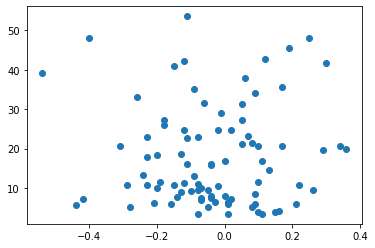

In [5]:



plt.scatter(metal, Prot)
plt.plot(metal, metal**(-0.005))



print('''There is no obvious direct relation between metalicity and rotation, but I suspect including it will benefit the model. 
Therefore, I will be adding onto the mean function and the GP fitting, as per the other values, I will jsut be using a simple power law dependance. 
Looking at work previosuly done by Louis Amard, we can expect a negeatve power law of small magnitude. I will set the prior on this value to be uniform between -0.01 and 0.
I will also add in a 3rd kernel to account for this variables behaviour in the GP. as done previosuly the priors on the lengthscale and amplitude will be determined by eye by looking at the data
this has worked well so far.''')

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [7]:
#### book ####


h = 0.4 
f = 0.601 
c = 0.5189 
A = 0.7725 * np.sqrt(1000) 

# fix barnes values 


X = np.array([Age, BV, metal]).T 
print(X.shape)
print(metal.shape)

with pm.Model() as model:
    #c_ = pm.Uniform('c_', c-0.007, c+0.007)
    c_ = pm.Normal('c_', c, 0.007)
    #c_ = c
    #f_ = pm.Uniform('f_', f-0.024, f+0.024)
    f_ = pm.Normal('f_', f, f*0.024)
    #f_ = f
    #A_ = pm.Uniform('A_', A*0.85, A*1.15)
    A_ = pm.Normal('A_', A, A*0.10)
    #A_ = A
    k_ = pm.Uniform('k_', -0.01, 0)  
    #k_ = 0
  
    Age_true = pm.Uniform('Age_true', 0, 14, shape=data_points)
    Age_obs = pm.Normal("Age_obs", Age_true, np.abs(Age_err), observed=X[:,0])


    

    BV_true = pm.Lognormal("BV_true", 1, 1, shape=data_points)
    BV_obs = pm.Normal("BV_obs", BV_true, np.abs(BV_err), observed=X[:,1])

    mean = mean_fn(Age_true, BV_true, A_,c_,h,f_, metal, k_)
    resid = Prot - mean
   
    l1 = pm.Normal('l1', mu=13, sigma=2)  # 20
    l2 = pm.Lognormal("l2", np.log(0.15), 0.1)
    l3 = pm.Normal("l3", 1.4, 0.2)

    sf1 = pm.Normal('sf1', 10, 2)
    sf2 = pm.Lognormal("sf2", np.log(0.2), 0.1)
    sf3 = pm.Normal('sf3', 5, 3)

    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2

    K = K1 * K2 * K3# try multiply 


    gp = pm.gp.Marginal(cov_func=K)


    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=np.abs(Prot_err))

    # big gp book says constnat plus a product of linear + white noise will do the trick




(88, 3)
(88,)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sf3, sf2, sf1, l3, l2, l1, BV_true, Age_true, k_, A_, f_, c_]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 2039 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


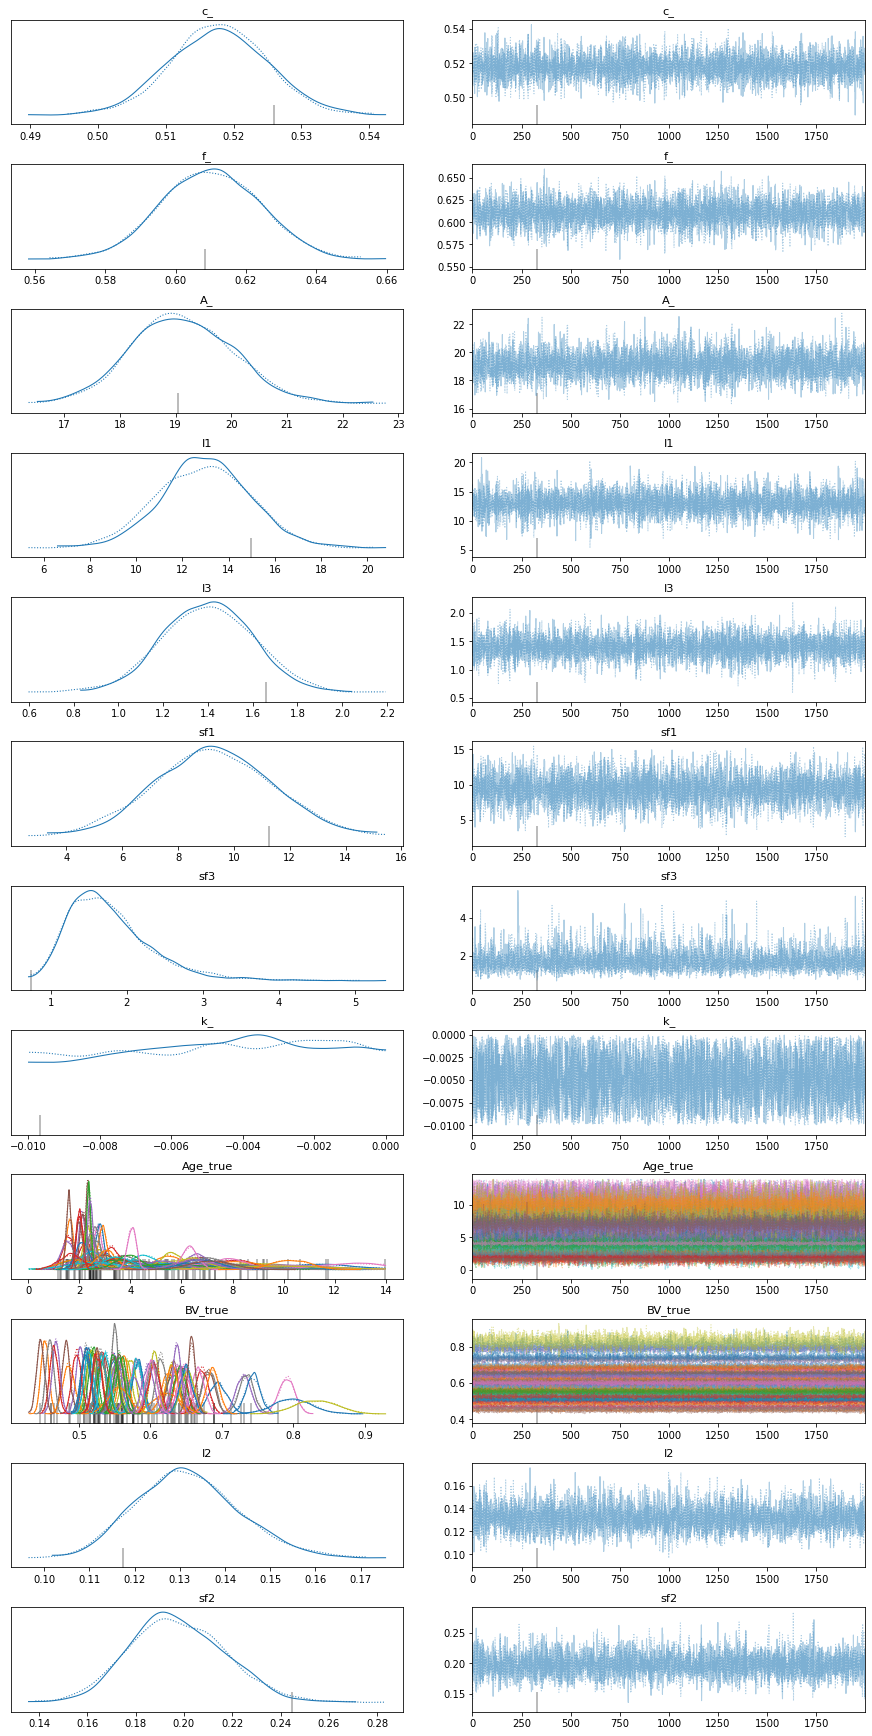

In [8]:

with model:
  trace = pm.sample(2000, tune=3000, cores=2, target_accept=0.95)
  arviz.plot_trace(trace)

In [9]:
with model:
  print(arviz.summary(trace))


lst = trace.varnames
lst.append('f_pred')
vars = np.asarray(lst)

with model:
  f_pred = gp.conditional('f_pred', X, pred_noise=False) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, var_names=vars,samples=2500)


                mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
c_             0.518  0.007   0.505  ...    7826.0    3085.0   1.00
f_             0.610  0.014   0.585  ...    8481.0    3140.0   1.00
A_            19.127  0.919  17.429  ...    6152.0    3062.0   1.00
l1            12.977  1.980   9.368  ...    7826.0    2545.0   1.00
l3             1.400  0.202   1.024  ...    8823.0    2879.0   1.00
sf1            9.277  2.097   5.305  ...    5186.0    2571.0   1.00
sf3            1.788  0.582   0.853  ...    4290.0    2172.0   1.00
k_            -0.005  0.003  -0.009  ...    7778.0    2550.0   1.00
Age_true[0]    2.940  0.413   2.130  ...    9254.0    2655.0   1.00
Age_true[1]    1.632  0.143   1.366  ...    7137.0    2695.0   1.00
Age_true[2]    3.322  0.751   1.855  ...    8275.0    2303.0   1.00
Age_true[3]    2.253  0.246   1.809  ...    9006.0    2675.0   1.00
Age_true[4]    2.107  0.128   1.853  ...    7343.0    2413.0   1.00
Age_true[5]    6.689  0.592   5.577  ...    9454

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [10]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


Initianl error:  15.726056036798965 %
New error:  14.121834315424097 %
Difference in error = -1.60422%  :)


In [11]:
print(trace.get_values('Age_true').shape)
Age_new = np.mean(trace.get_values('Age_true'), axis=0)
BV_new = np.mean(trace.get_values('BV_true'), axis=0)
print(Age_new.shape)

(4000, 88)
(88,)


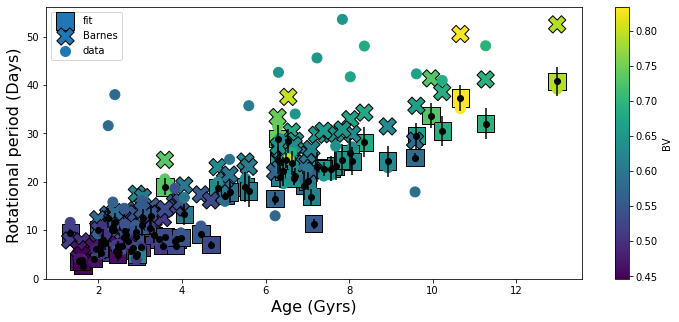

"\nfig = plt.figure(figsize=(12, 5))\nplt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')\n#plt.scatter(X[:,0], mu - fit, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis, label='barnes',edgecolors='k')\nplt.scatter(X[:,0], mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601), s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='Barnes', edgecolors='k')\nplt.xlabel('Age (Gyrs)', fontsize=16)\nplt.ylabel('Rotational period (Days) ', fontsize=16)\nplt.colorbar(label='BV')\nplt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')\n\n\n\nplt.legend()\nplt.savefig('col_fit_comp.png')\nfiles.download('col_fit_comp.png')\n\nplt.show()\n"

In [12]:
 

A = np.mean(trace['A_'])
c = np.mean(trace['c_'])
h = h
f = np.mean(trace['f_'])


'''
'''
k = np.mean(trace['k_'])

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()



fit, var = gp.predict(X, point=trace[-1], diag=True)
std = np.sqrt(var)


mean = mean_fn(X[:,0], X[:,1], A, c ,h,f, X[:,2], k)

mu = fit + mean



## plotting the predictions, make a plot of age on x axis b-v on y, plot points and colour by age




#plt.plot([],[], color='w',label='A = {}\n c = {}\n f = {}'.format(round(A,4), round(c,4), round(f,4)))

plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')
plt.scatter(X[:,0], mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601, metal, 0), s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='Barnes', edgecolors='k')


plt.errorbar(X[:,0], mu, yerr=std, fmt='ok')
#plt.errorbar(X[:,0], Prot, yerr=Prot_err, fmt='ok')

plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.colorbar(label='BV')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')
plt.legend()
plt.savefig('col_Ba.png')
#files.download('col_Ba.png')
plt.show()

'''
fig = plt.figure(figsize=(12, 5))
plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')
#plt.scatter(X[:,0], mu - fit, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis, label='barnes',edgecolors='k')
plt.scatter(X[:,0], mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601), s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='Barnes', edgecolors='k')
plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.colorbar(label='BV')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')



plt.legend()
plt.savefig('col_fit_comp.png')
files.download('col_fit_comp.png')

plt.show()
'''

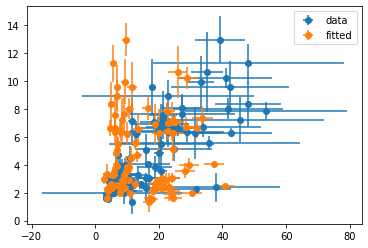

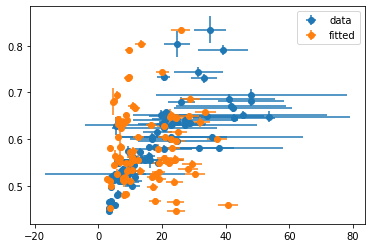

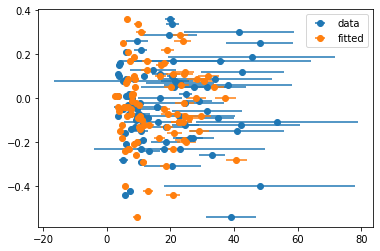

In [13]:



vals = np.sort(np.array([mu, std, Prot, Prot_err]), axis=1)





age_fit_err = [trace.get_values('Age_true')[:,i].std() for i in range(trace.get_values('Age_true').shape[1])]
bv_fit_err = [trace.get_values('BV_true')[:,i].std() for i in range(trace.get_values('BV_true').shape[1])]


plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(vals[0,:], X[:,0], xerr=vals[1,:], yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')



order = np.argsort(X[:,1])


plt.errorbar(vals[0,:][order], X[:,1][order], xerr=vals[1,:][order], yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()



plt.errorbar(Prot, X[:,2], xerr=Prot_err, fmt='o', label='data')
plt.errorbar(vals[0,:], X[:,2], xerr=vals[1,:], fmt='o', label='fitted')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

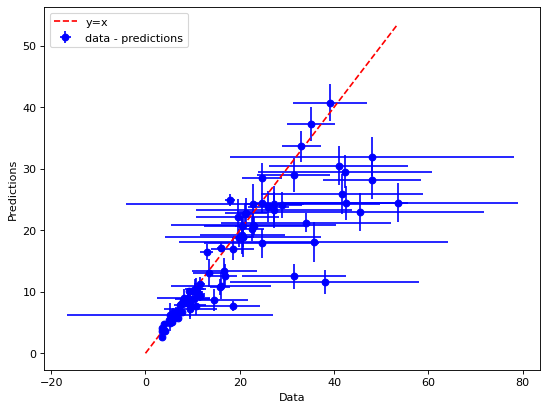

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

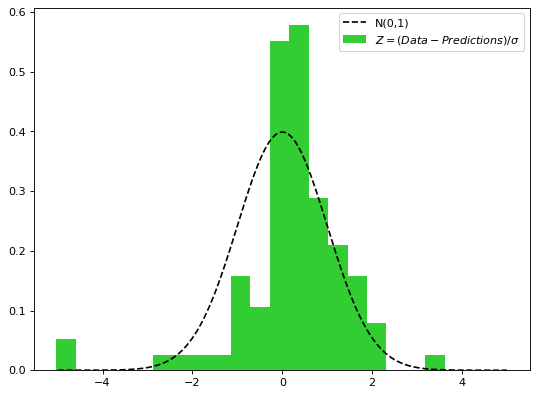

0.2293631969132888


In [14]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot([0, np.amax(vals[2,:])], [0, np.amax(vals[2,:])], linestyle='--', label='y=x', color='r')


plt.errorbar(Prot, mu, yerr=std, xerr=Prot_err, fmt='o', label=r'data - predictions', color='b', alpha=1)



#plt.fill_between(vals[2,:], vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], alpha=0.3, label=r'$\sigma$',interpolate=True, color='blue')
#plt.fill_between(vals[2,:], vals[0,:] - 2*vals[1,:], vals[0,:] + 2*vals[1,:], alpha=0.2, label=r'$2\sigma$', interpolate=True, color='b')
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.savefig("R_Ba.png")
files.download("R_Ba.png") 
plt.legend()
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.show()


Z = (Prot - mu)/np.sqrt(std**2 + Prot_err**2)
x = np.linspace(-5,5, 1000)
norm = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(Z, density=True, label=r'$Z=(Data-Predictions)/\sigma$', color='limegreen', bins=20)
plt.plot(x,norm, label='N(0,1)', color='k', linestyle='--')
plt.legend()
plt.savefig("H_Ba.png")
files.download("H_Ba.png") 
plt.show()
print(Z.mean())



In [15]:
#print(np.mean(Z))
left = 1
right = -1
#print(np.std(Z))
k = np.argsort(Z)
#print(Z[k])
print('These are the bad ones.')
print('rot',Prot[k[:left]], Prot[k[right:]])


print('age',Age[k[:left]], Age[k[right:]])
print('B-V',BV[k[:left]], BV[k[right:]])
print('Rotation error', Prot_err[k[:left]], Prot_err[k[right:]])
print('mass', Mass[k[:left]], Mass[k[right:]])
print('mtealicity',metal[k[:left]], metal[k[right:]])
print('mu', mu[k[:left]], mu[k[right:]])
print('std', std[k[:left]], std[k[right:]])




'''
have found that stars above the kraft break 1.3 do not follow the patterns we are expecting, so we are going to remove stars above. Consistent with kfraft break where we get shallowe
convective zones, torques dynamos etc.
agreeing wiht eh metalcity paper, have found that lower metalicty stars spin slower. 


compare with all stars, outliars 3 high mass 1 very metal poor. Kill x most massive stats, if the new run has more massive outliars kill y more. Would be best to go as high
as we can. If we can disprove the Kraft Break, its gonna be a continuum. If our model can account for these high mass stars, can speculate validty of Kraft break
'''

These are the bad ones.
rot [17.90107245] [3.4991141]
age [9.5801] [1.627]
B-V [0.5834773] [0.45218772]
Rotation error [1.01742008] [0.16307147]
mass [0.9389] [1.4291]
mtealicity [-0.23] [0.01]
mu [24.9814149] [2.66794851]
std [0.97067556] [0.16225802]


'\nhave found that stars above the kraft break 1.3 do not follow the patterns we are expecting, so we are going to remove stars above. Consistent with kfraft break where we get shallowe\nconvective zones, torques dynamos etc.\nagreeing wiht eh metalcity paper, have found that lower metalicty stars spin slower. \n\n\ncompare with all stars, outliars 3 high mass 1 very metal poor. Kill x most massive stats, if the new run has more massive outliars kill y more. Would be best to go as high\nas we can. If we can disprove the Kraft Break, its gonna be a continuum. If our model can account for these high mass stars, can speculate validty of Kraft break\n'

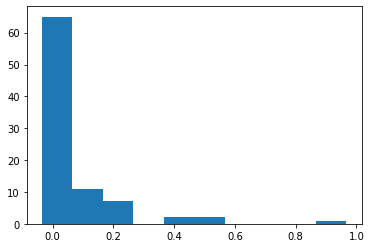

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

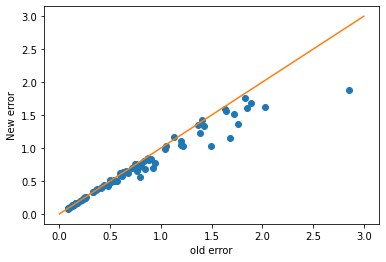

In [16]:
  
### Fix B-V for sveral valuea and plot age vs roation for Barnes and GP. Should see that for Young stars, Barnes and GP agree fairly well as Barnes callibrated on young stars. On Older Barnes will be bad. GP has more flexibility. Should wee GP predicticint faster than Barnes.

#histogram of the differences between old uncertaintiy and new uncertainity(latent variables SD)
new_err = ([ trace.get_values('Age_true')[:,i].std()for i in range(data_points)])
old_err = Age_err
plt.hist(old_err - new_err)
plt.show()
plt.plot(old_err, new_err,'o')
plt.plot([0,3], [0,3])
plt.xlabel('old error')
plt.ylabel('New error')
plt.savefig('err_diff_Ba.png')
files.download('err_diff_Ba.png')
# give this a section 

In [17]:
new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


Initianl error:  15.726056036798965 %
New error:  14.121834315424097 %
Difference in error = -1.60422%  :)


These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V